In [2]:
#importing all the required modules

import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from tqdm import tqdm
import random
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sn
import glob
from skimage.io import imread
import cv2
from cv2 import resize
import os
import PIL
import datetime
import pandas
!rm -rf ./.logs/
from sklearn.metrics import confusion_matrix , classification_report
from pylab import imshow
from keras.models import Model
from keras import backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [3]:
#setting up the seed value
seed = 42
np.random.seed = seed

In [4]:
#Dice coeeficient to measure accuracy of the model

def dice_coef(y_true, y_pred, smooth=1):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)   
    intersection = K.sum(y_true * y_pred)
    dice = (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
    return dice

def dice_loss(y_true, y_pred):
  loss = 1 - dice_coef(y_true, y_pred)
  return loss    


In [5]:
#Defining the U-net model

def Unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
  
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = inputs
  m=64

  c1 = Conv2D(m, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = Dropout(0.1)(c1)
  c1 = Conv2D(m, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(2*m, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv2D(2*m, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  c3 = Conv2D(4*m, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(4*m, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = MaxPooling2D((2, 2))(c3)

  c4 = Conv2D(8*m, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(8*m, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
  c5 = Conv2D(16*m, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv2D(16*m, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  u6 = Conv2DTranspose(8*m, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(8*m, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = Dropout(0.3)(c6)
  c6 = Conv2D(8*m, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

  u7 = Conv2DTranspose(4*m, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(4*m, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(4*m, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
  u8 = Conv2DTranspose(2*m, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(2*m, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv2D(2*m, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

  u9 = Conv2DTranspose(m, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(m, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv2D(m, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=[dice_coef])
  model.summary()
  
  return model

In [6]:
#Model summary
model= Unet_model(512, 512, 1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       dropout[0][0]                    
______________________________________________________________________________________________

In [7]:
# Mouting my drive to import images
# Images have been put up in their respective folder in this repsitory for your reference
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#Sorting the images to match them with their respective label images

img_list_x_train = sorted(glob.glob('/content/drive/My Drive/Skin Cancer data/train/image/*.png'), key=lambda x: x[-6:-4])

In [9]:
#Visualizing the images in training set
img_list_x_train

['/content/drive/My Drive/Skin Cancer data/train/image/0.png',
 '/content/drive/My Drive/Skin Cancer data/train/image/1.png',
 '/content/drive/My Drive/Skin Cancer data/train/image/2.png',
 '/content/drive/My Drive/Skin Cancer data/train/image/3.png',
 '/content/drive/My Drive/Skin Cancer data/train/image/4.png',
 '/content/drive/My Drive/Skin Cancer data/train/image/5.png',
 '/content/drive/My Drive/Skin Cancer data/train/image/6.png',
 '/content/drive/My Drive/Skin Cancer data/train/image/7.png',
 '/content/drive/My Drive/Skin Cancer data/train/image/8.png',
 '/content/drive/My Drive/Skin Cancer data/train/image/9.png',
 '/content/drive/My Drive/Skin Cancer data/train/image/10.png',
 '/content/drive/My Drive/Skin Cancer data/train/image/11.png',
 '/content/drive/My Drive/Skin Cancer data/train/image/12.png',
 '/content/drive/My Drive/Skin Cancer data/train/image/13.png',
 '/content/drive/My Drive/Skin Cancer data/train/image/14.png',
 '/content/drive/My Drive/Skin Cancer data/train/i

In [10]:
#Sorting the images to match them with their respective train images
img_list_y_train = sorted(glob.glob('/content/drive/My Drive/Skin Cancer data/train/label/*.png'), key=lambda x: x[-6:-4])

In [11]:
#Visualizing the images in label set
img_list_y_train

['/content/drive/My Drive/Skin Cancer data/train/label/0.png',
 '/content/drive/My Drive/Skin Cancer data/train/label/1.png',
 '/content/drive/My Drive/Skin Cancer data/train/label/2.png',
 '/content/drive/My Drive/Skin Cancer data/train/label/3.png',
 '/content/drive/My Drive/Skin Cancer data/train/label/4.png',
 '/content/drive/My Drive/Skin Cancer data/train/label/5.png',
 '/content/drive/My Drive/Skin Cancer data/train/label/6.png',
 '/content/drive/My Drive/Skin Cancer data/train/label/7.png',
 '/content/drive/My Drive/Skin Cancer data/train/label/8.png',
 '/content/drive/My Drive/Skin Cancer data/train/label/9.png',
 '/content/drive/My Drive/Skin Cancer data/train/label/10.png',
 '/content/drive/My Drive/Skin Cancer data/train/label/11.png',
 '/content/drive/My Drive/Skin Cancer data/train/label/12.png',
 '/content/drive/My Drive/Skin Cancer data/train/label/13.png',
 '/content/drive/My Drive/Skin Cancer data/train/label/14.png',
 '/content/drive/My Drive/Skin Cancer data/train/l

In [12]:
#assigning new array to store images 
IMG_SIZE = 512
x_train = np.empty((len(img_list_x_train), IMG_SIZE, IMG_SIZE), dtype=np.float32)
y_train = np.empty((len(img_list_y_train), IMG_SIZE, IMG_SIZE), dtype=np.float32)

In [13]:
# Array shape of train set images
x_train.shape

(30, 512, 512)

In [14]:
#assigning images as matrices in the new array made above

for i, img_path in enumerate(img_list_x_train):
    # read image
    img = imread(img_path)
    # save to numpy array
    x_train[i] = img

for i, img_path in enumerate(img_list_y_train):
    # read image
    img = imread(img_path)
    # save to numpy array
    y_train[i] = img

In [15]:
#normalizing the values of the pixels of train set images from (0 to 255) to (0.0 to 1.0) 
x_train_with_chanels = (x_train.reshape(x_train.shape[0], 512, 512, 1))/255
y_train_with_chanels = (y_train.reshape(y_train.shape[0], 512, 512, 1))/255

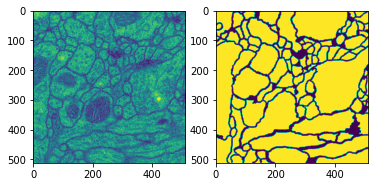

In [16]:
#plotting a random image and its label image

f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[16])
axarr[1].imshow(y_train[16])

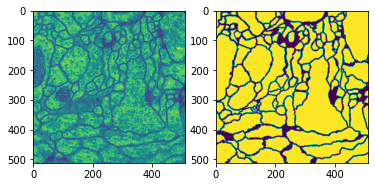

In [18]:
#plotting another random image and its label image

f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[9])
axarr[1].imshow(y_train[9])

In [19]:
#sorting the test set images
img_list_x_test = sorted(glob.glob('/content/drive/My Drive/Skin Cancer data/test/*[0-9].*png'), key=lambda x: x[-6:-4])
img_list_y_test = sorted(glob.glob('/content/drive/My Drive/Skin Cancer data/test/*_predict*.png'), key=lambda x: x[-14:-12])

In [20]:
#Listing the test set images
img_list_x_test

['/content/drive/My Drive/Skin Cancer data/test/0.png',
 '/content/drive/My Drive/Skin Cancer data/test/1.png',
 '/content/drive/My Drive/Skin Cancer data/test/2.png',
 '/content/drive/My Drive/Skin Cancer data/test/3.png',
 '/content/drive/My Drive/Skin Cancer data/test/4.png',
 '/content/drive/My Drive/Skin Cancer data/test/5.png',
 '/content/drive/My Drive/Skin Cancer data/test/6.png',
 '/content/drive/My Drive/Skin Cancer data/test/7.png',
 '/content/drive/My Drive/Skin Cancer data/test/8.png',
 '/content/drive/My Drive/Skin Cancer data/test/9.png',
 '/content/drive/My Drive/Skin Cancer data/test/10.png',
 '/content/drive/My Drive/Skin Cancer data/test/11.png',
 '/content/drive/My Drive/Skin Cancer data/test/12.png',
 '/content/drive/My Drive/Skin Cancer data/test/13.png',
 '/content/drive/My Drive/Skin Cancer data/test/14.png',
 '/content/drive/My Drive/Skin Cancer data/test/15.png',
 '/content/drive/My Drive/Skin Cancer data/test/16.png',
 '/content/drive/My Drive/Skin Cancer dat

In [21]:
#Listing the test label set images
img_list_y_test

['/content/drive/My Drive/Skin Cancer data/test/0_predict.png',
 '/content/drive/My Drive/Skin Cancer data/test/1_predict.png',
 '/content/drive/My Drive/Skin Cancer data/test/2_predict.png',
 '/content/drive/My Drive/Skin Cancer data/test/3_predict.png',
 '/content/drive/My Drive/Skin Cancer data/test/4_predict.png',
 '/content/drive/My Drive/Skin Cancer data/test/5_predict.png',
 '/content/drive/My Drive/Skin Cancer data/test/6_predict.png',
 '/content/drive/My Drive/Skin Cancer data/test/7_predict.png',
 '/content/drive/My Drive/Skin Cancer data/test/8_predict.png',
 '/content/drive/My Drive/Skin Cancer data/test/9_predict.png',
 '/content/drive/My Drive/Skin Cancer data/test/10_predict.png',
 '/content/drive/My Drive/Skin Cancer data/test/11_predict.png',
 '/content/drive/My Drive/Skin Cancer data/test/12_predict.png',
 '/content/drive/My Drive/Skin Cancer data/test/13_predict.png',
 '/content/drive/My Drive/Skin Cancer data/test/14_predict.png',
 '/content/drive/My Drive/Skin Canc

In [22]:
#Assigning new array to store test set images
x_test = np.empty((len(img_list_x_test), 512, 512), dtype=np.uint8)

In [23]:
#assigning test set images as matrices in the new array made above
for i, img_path in enumerate(img_list_x_test):
    # read image
    img = imread(img_path)
    # save to numpy array
    x_test[i] = img

In [24]:
#normalizing the values of the pixels of test set images from (0 to 255) to (0.0 to 1.0)
x_test_with_chanels = (x_test.reshape(x_test.shape[0], 512, 512, 1))/255

In [25]:
#visualizing the test image set array
x_test.shape

(30, 512, 512)

In [26]:
# test set images with 1 channel
x_test_with_chanels.shape

(30, 512, 512, 1)

In [28]:
#defining the callback parameters for the model
callbacks = [
              tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_loss'),
              tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [30]:
#training the model (parameters= epochs=50, batch size=4, validation split=0.1)
results = model.fit(x_train_with_chanels, y_train_with_chanels, validation_split=0.1, batch_size=4, epochs=50, callbacks=callbacks)

Epoch 1/50
7/7 [==============================] - 85s 8s/step - loss: 2.5219 - dice_coef: 0.7374 - val_loss: 0.4688 - val_dice_coef: 0.7719
Epoch 2/50
7/7 [==============================] - 21s 3s/step - loss: 0.8198 - dice_coef: 0.7115 - val_loss: 0.4287 - val_dice_coef: 0.8426
Epoch 3/50
7/7 [==============================] - 21s 3s/step - loss: 0.4692 - dice_coef: 0.8299 - val_loss: 0.4260 - val_dice_coef: 0.8267
Epoch 4/50
7/7 [==============================] - 21s 3s/step - loss: 0.4619 - dice_coef: 0.8034 - val_loss: 0.4217 - val_dice_coef: 0.8241
Epoch 5/50
7/7 [==============================] - 21s 3s/step - loss: 0.4530 - dice_coef: 0.8193 - val_loss: 0.4089 - val_dice_coef: 0.8342
Epoch 6/50
7/7 [==============================] - 21s 3s/step - loss: 0.4415 - dice_coef: 0.8149 - val_loss: 0.3895 - val_dice_coef: 0.8418
Epoch 7/50
7/7 [==============================] - 21s 3s/step - loss: 0.4197 - dice_coef: 0.8243 - val_loss: 0.3572 - val_dice_coef: 0.8552
Epoch 8/50
7/7 [====

In [31]:
#method to save model
#model.save('/content/drive/MyDrive/nitk_skin_cancer/skin_cancer_personal.h5')

In [32]:
#method to load model weights from a saved file
#model.load_weights('/content/drive/MyDrive/nitk_skin_cancer/skin_cancer_personal.h5')

In [47]:
#predicting the ouput of the model
preds_test = model.predict(x_test_with_chanels, batch_size=4, verbose=1)

preds_test_t = (preds_test > 0.56).astype(np.uint8)

8/8 [==============================] - 8s 1s/step


In [48]:
#reshaping the output predicted by the model
preds_test_t = preds_test_t.reshape(preds_test_t.shape[0], 512, 512)

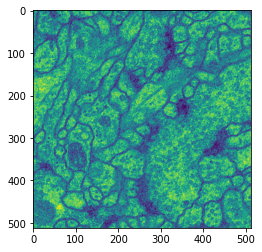

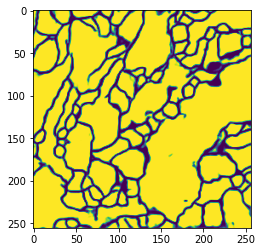

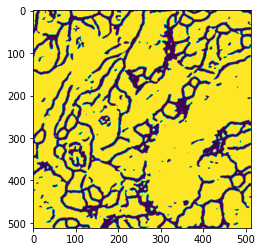

In [49]:
#plotting test image, its label, and the image predicted by the model for a random image
img = imread('/content/drive/My Drive/Skin Cancer data/test/9_predict.png')
imshow(x_test[9])
plt.show()
imshow(np.squeeze(img))
plt.show()
imshow(np.squeeze(preds_test_t[9]))
plt.show()

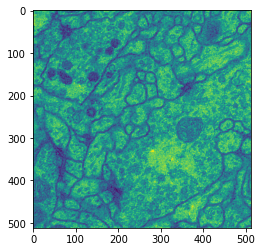

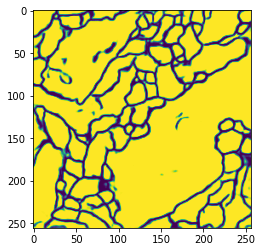

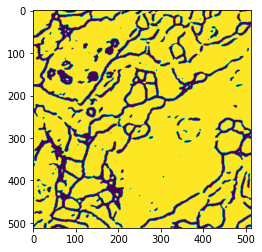

In [50]:
#plotting test image, its label, and the image predicted by the model for a random image
img = imread('/content/drive/My Drive/Skin Cancer data/test/3_predict.png')
imshow(x_test[3])
plt.show()
imshow(np.squeeze(img))
plt.show()
imshow(np.squeeze(preds_test_t[3]))
plt.show()

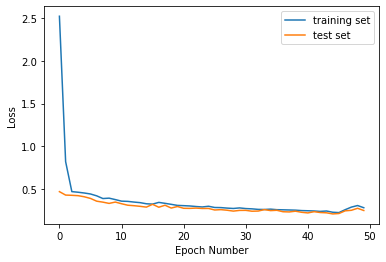

In [51]:
#plotting the Loss values vs number of epochs
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(results.history['loss'], label='training set')
plt.plot(results.history['val_loss'], label='test set')
plt.legend()

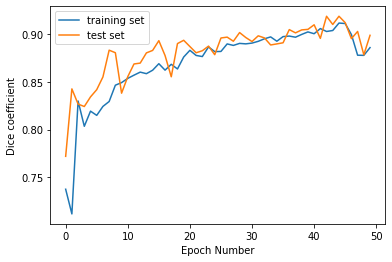

In [52]:
#plotting the dice coefficient vs number of epochs
plt.xlabel('Epoch Number')
plt.ylabel('Dice coefficient')
plt.plot(results.history['dice_coef'], label='training set')
plt.plot(results.history['val_dice_coef'], label='test set')
plt.legend()